In [ ]:
install.packages("foreign")  # foreign 패키지 설치

In [1]:
library(foreign)             # SPSS 파일 로드
library(dplyr)               # 전처리
library(ggplot2)             # 시각화
library(readxl)              # 엑셀 파일 불러오기

Warning message:
"package 'foreign' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'readxl' was built under R version 3.6.2"

In [4]:
raw_welfare <- read.spss(file='../data/Koweps_hpc10_2015_beta1.sav', to.data.frame = T)
welfare <- raw_welfare

Warning message in read.spss(file = "../data/Koweps_hpc10_2015_beta1.sav", to.data.frame = T):
"../data/Koweps_hpc10_2015_beta1.sav: Compression bias (0) is not the usual value of 100"

In [ ]:
str(welfare)

#### 변수명 바꾸기

In [5]:
welfare <- rename(welfare,
                  sex = h10_g3,            # 성별
                  birth = h10_g4,          # 태어난 연도
                  marriage = h10_g10,      # 혼인 상태
                  religion = h10_g11,      # 종교
                  income = p1002_8aq1,     # 월급
                  code_job = h10_eco9,     # 직종 코드
                  code_region = h10_reg7)  # 지역 코드

In [ ]:
# 4pm


In [4]:
class(welfare$sex)
table(welfare$sex)

[1] "numeric"


   1    2 
7578 9086 

In [6]:
# 2. 전처리
# 이상치 확인
table(welfare$sex)


   1    2 
7578 9086 

In [ ]:
#  이상치 결측 처리
# welfare$sex <- ifelse(welfare$sex == 9, NA, welfare$sex)
# # 결측치 확인
# table(is.na(welfare$sex))


female   male 
  9086   7578 

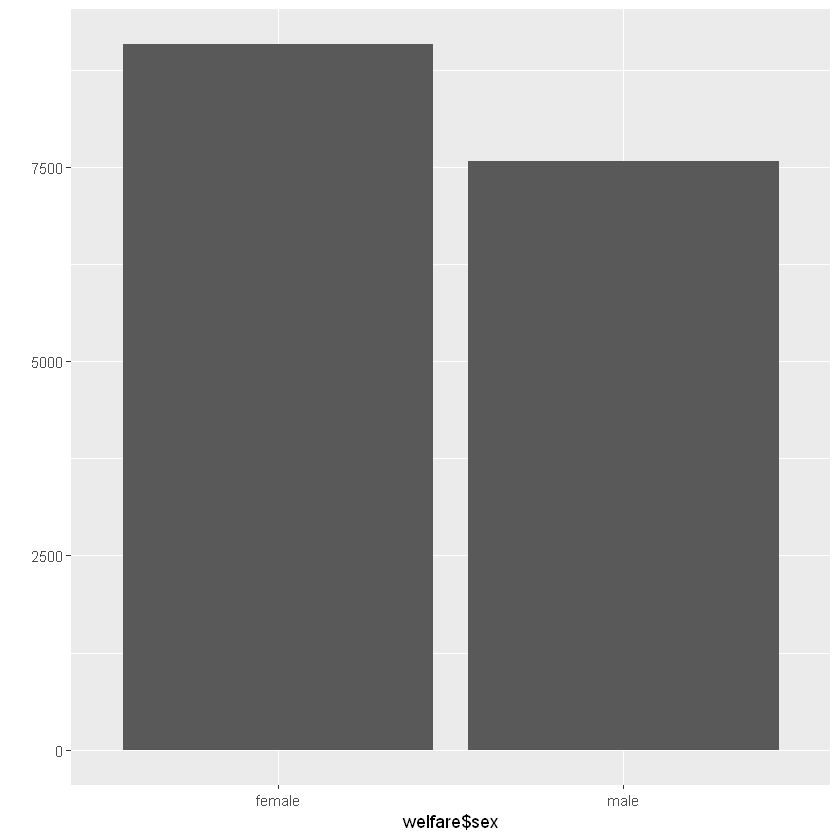

In [7]:
# 성별 항목 이름 부여
welfare$sex <- ifelse(welfare$sex == 1, "male", "female")
table(welfare$sex)
qplot(welfare$sex)

월급에 대한 전처리


In [5]:
# 변수 검토 1 : 
class(welfare$income)

[1] "numeric"

In [6]:
summary(welfare$income)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
    0.0   122.0   192.5   241.6   316.6  2400.0   12030 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
"Removed 12030 rows containing non-finite values (stat_bin)."

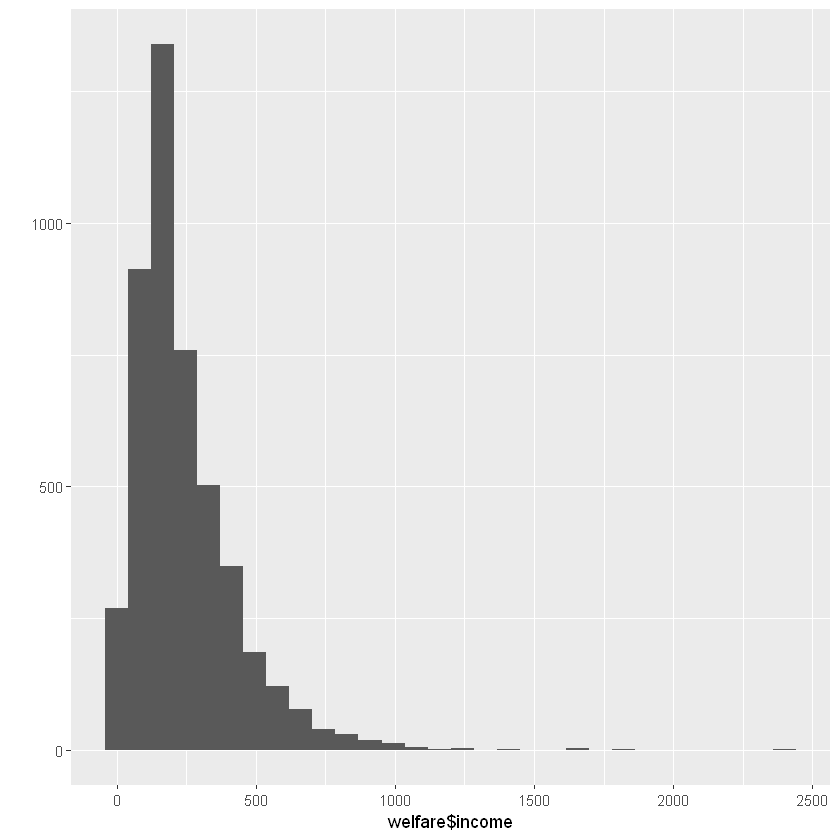

In [9]:
qplot(welfare$income)

In [10]:
# 이상치 결측 처리
welfare$income <- ifelse(welfare$income %in% c(0, 9999), NA, welfare$income)

In [11]:
# 결측치 확인
table(is.na(welfare$income))


FALSE  TRUE 
 4620 12044 

In [8]:
sex_income <- welfare %>%
  filter(!is.na(income)) %>%
  group_by(sex) %>%
  summarise(mean_income = mean(income))

### 몇살 때 월급이 가장 많이 받을까.?

- 나이, 월급에 따른 분석

In [12]:
class(welfare$birth)

[1] "numeric"

In [13]:
summary(welfare$birth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1907    1946    1966    1968    1988    2014 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


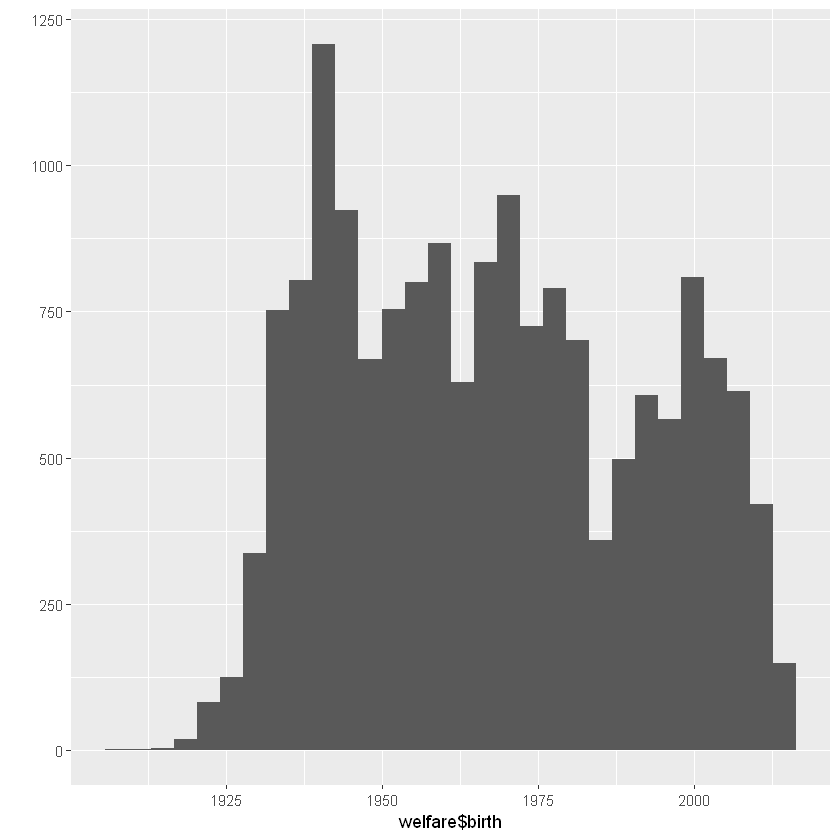

In [14]:
qplot(welfare$birth)

- 이상치확인

In [15]:
# 이상치 확인
summary(welfare$birth)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1907    1946    1966    1968    1988    2014 

In [16]:
# 결측치 확인
table(is.na(welfare$birth))


FALSE 
16664 

### 파생 변수 만들기
- 나이

In [17]:
# 2015년 기준으로 나이 계산. / 한국 나이계산은 +1
welfare$age <- 2015 - welfare$birth + 1
summary(welfare$age) 

# 2 ~ 109살까지 ㄷㄷ..

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   2.00   28.00   50.00   48.43   70.00  109.00 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


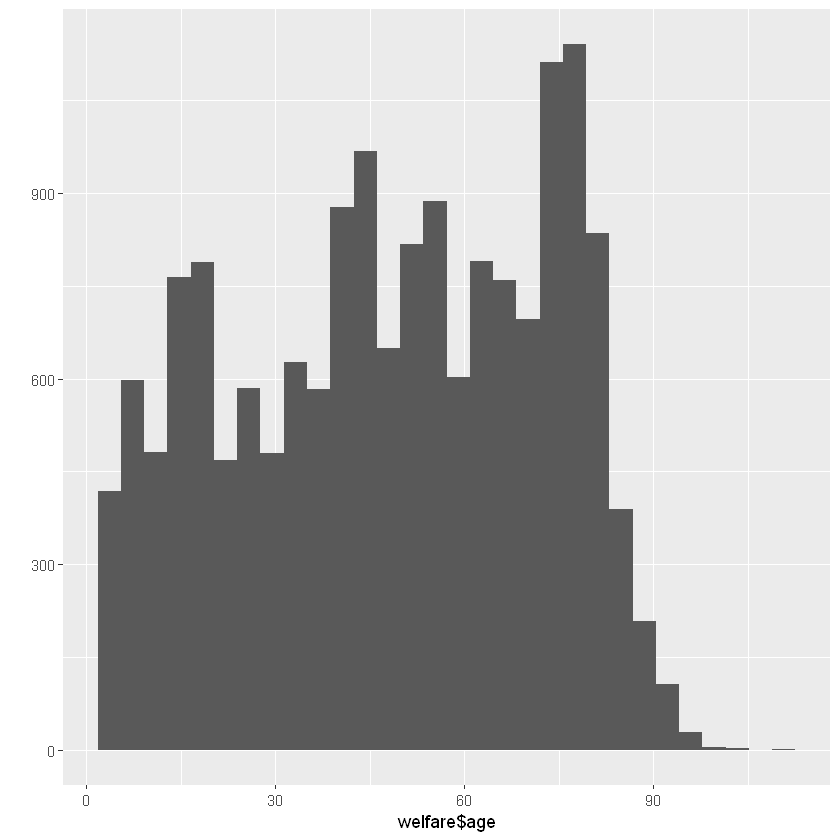

In [18]:
qplot(welfare$age)

In [19]:
# 나이를 시계열? 범주? => 범주형.
age_income <- welfare %>%
  filter(!is.na(income)) %>%
  group_by(age) %>%
  summarise(mean_income = mean(income))
head(age_income)

age,mean_income
20,121.3000
21,105.5185
22,130.0923
23,141.7157
24,134.0877
25,144.6559


시계열은 아니지만, 선그래프로 알아보자.

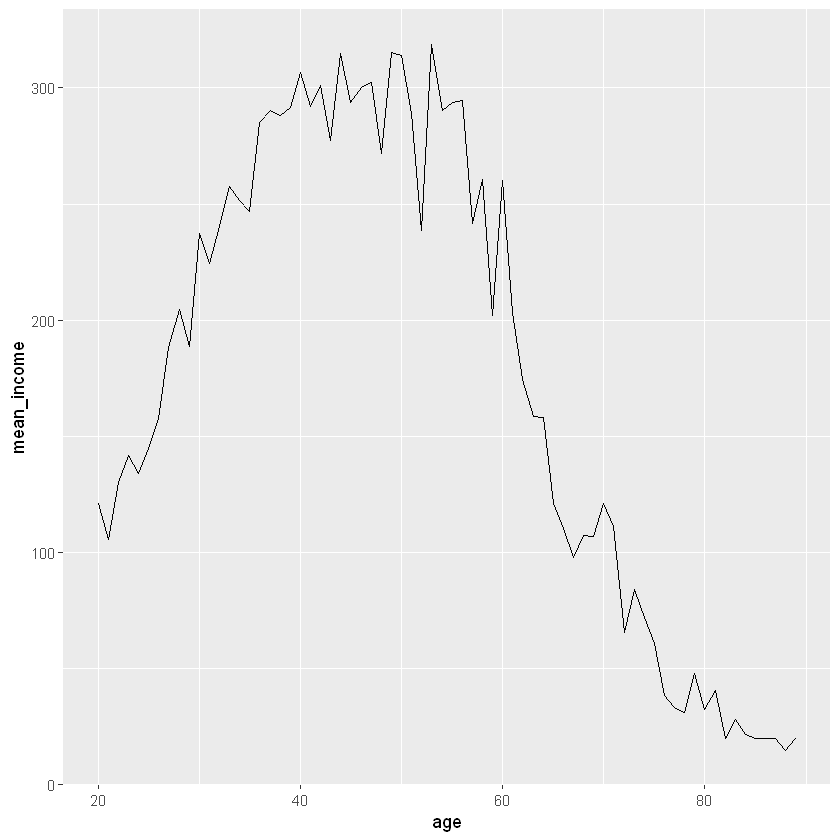

In [20]:
ggplot(data = age_income, aes(x = age, y = mean_income)) + geom_line()

### 정리해서 보기 -> 연령으로반 보니 너무 넓어서. 연령대별로 조절하기.

In [21]:
#
welfare <- welfare %>% 
 mutate(ageg = ifelse(age < 30, "young", # 30대이전
                      ifelse(age <= 59,"middle", "old")))
table(welfare$ageg)


middle    old  young 
  6049   6281   4334 

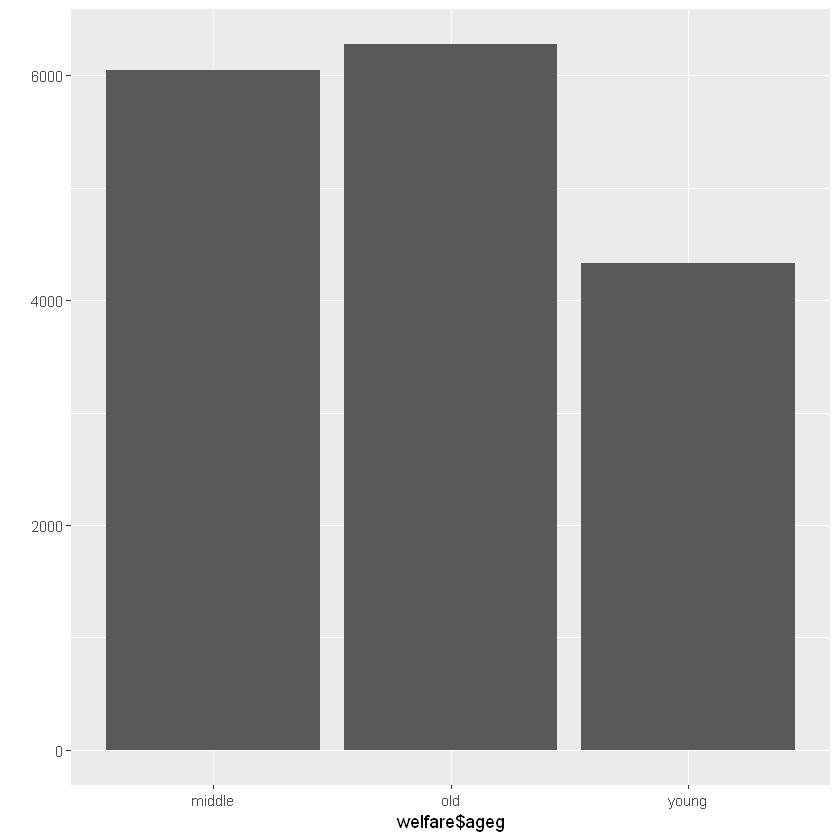

In [22]:
qplot(welfare$ageg)

In [23]:
ageg_income <- welfare %>%
  filter(!is.na(income)) %>%
  group_by(ageg) %>%
  summarise(mean_income = mean(income))
ageg_income

ageg,mean_income
middle,281.8871
old,125.3295
young,163.5953


In [ ]:
ggplot(data = ageg_income, aes(x = ageg, y = mean_income)) + geom_col()

In [ ]:
#막대 정렬 : 초년, 중년, 노년 나이 순
ggplot(data = ageg_income, aes(x = ageg, y = mean_income)) +
  geom_col() +
  scale_x_discrete(limits = c("young", "middle", "old"))

## 09-5. 연령대 및 성별 월급 차이

In [24]:
# 연령대별 및 성별 월급 평균포 만들기
# 4 ~ 50 대의 남녀.
# 테이블을 머리에 그리자. 연령대별과 그 해당하는성별까짇로도 구분.
sex_income <- welfare  %>% 
 filter(!is.na(income)) %>% 
 group_by(ageg, sex) %>%  
 summarise(mean_income = mean(income))
sex_income

ageg,sex,mean_income
middle,female,187.97552
middle,male,353.07574
old,female,81.52917
old,male,173.85558
young,female,159.50518
young,male,170.81737


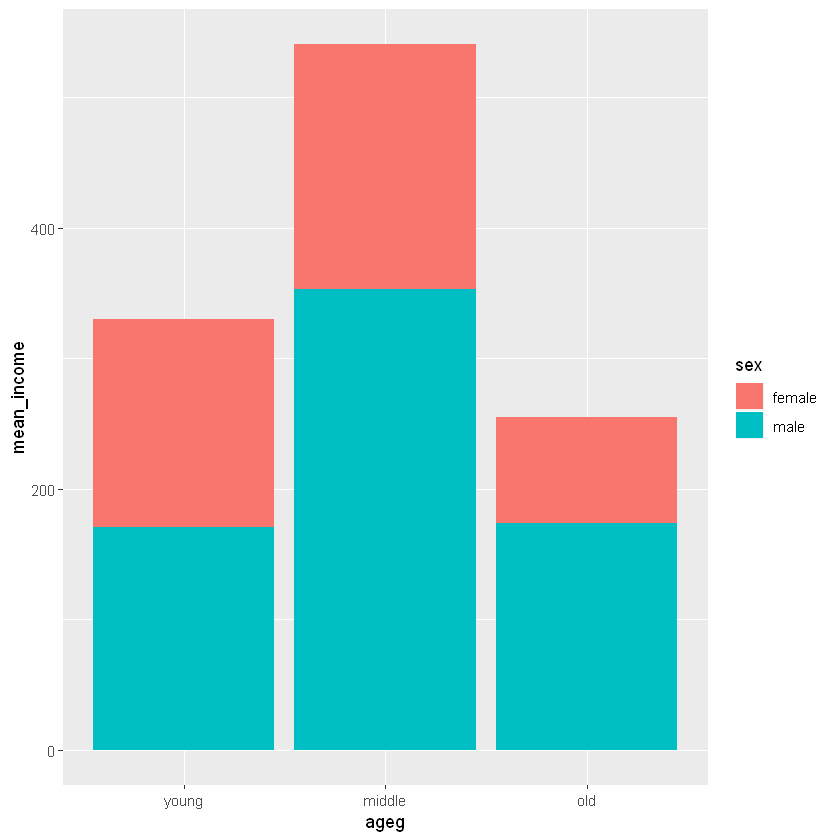

In [25]:
# 고소득자?의 차이 # 회사사장님? 
ggplot(data = sex_income, aes(x = ageg, y = mean_income, fill = sex)) + # fill : 색깔채우기.
  geom_col() +
  scale_x_discrete(limits = c("young", "middle", "old"))

In [ ]:
# 스토리 : 이러카면 조아!(당신에게)
# 

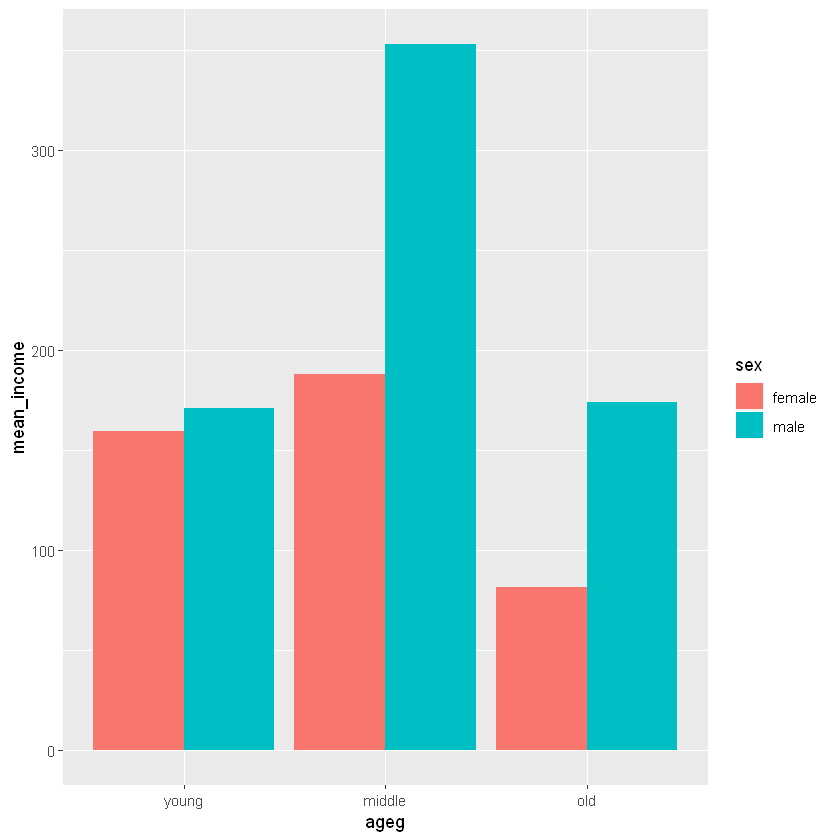

In [26]:
# 옵션 dodge를 주면 
# 막대그래프가 stack 이 아닌 따로 보여줌.
ggplot(data = sex_income, aes(x = ageg, y = mean_income, fill = sex)) +
  geom_col(position = "dodge") +
  scale_x_discrete(limits = c("young", "middle", "old"))

In [27]:
### 나이 및 성별 월급 차이 분석하기

# 성별 연령별 월급 평균표 만들기
sex_age <- welfare %>%
  filter(!is.na(income)) %>%
  group_by(age, sex) %>%
  summarise(mean_income = mean(income))


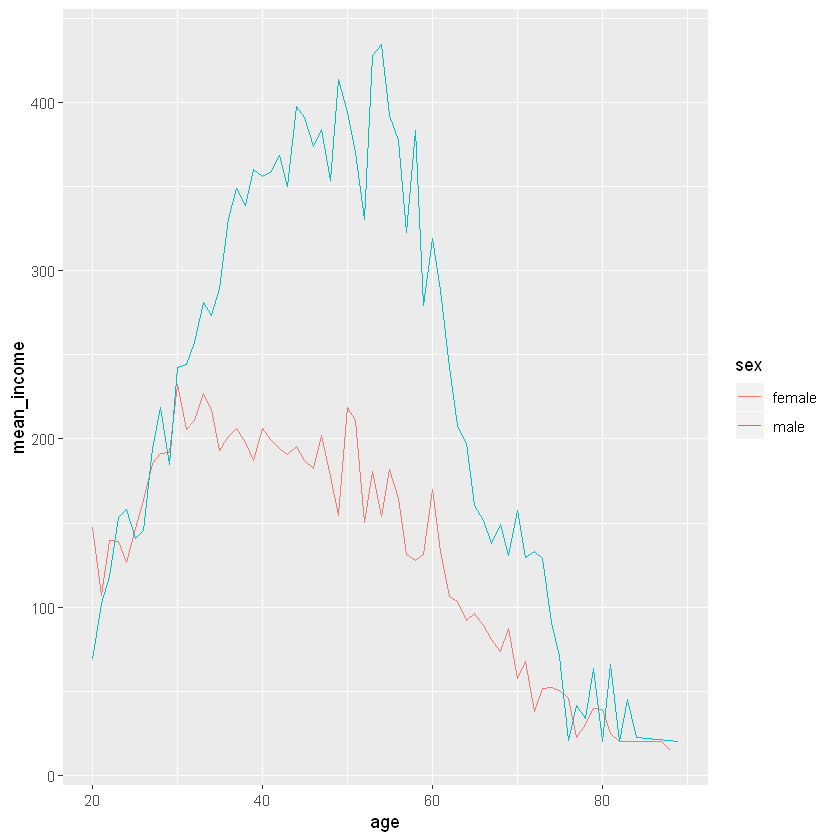

In [28]:
# 30 ~ 40 대엔 차이가 나느것을 선으로 볼 수 있다.
ggplot(data = sex_age, aes(x = age, y = mean_income, col = sex)) + geom_line()

In [29]:
class(welfare$code_job)

[1] "numeric"

In [30]:
table(welfare$code_job)


 111  120  131  132  133  134  135  139  141  149  151  152  153  159  211  212 
   2   16   10   11    9    3    7   10   35   20   26   18   15   16    8    4 
 213  221  222  223  224  231  232  233  234  235  236  237  239  241  242  243 
   3   17   31   12    4   41    5    3    6   48   14    2   29   12    4   63 
 244  245  246  247  248  251  252  253  254  259  261  271  272  273  274  281 
   4   33   59   77   38   14  111   24   67  109    4   15   11    4   36   17 
 283  284  285  286  289  311  312  313  314  320  330  391  392  399  411  412 
   8   10   26   16    5  140  260  220   84   75   15    4   13   87   47   12 
 421  422  423  429  431  432  441  442  510  521  522  530  611  612  613  620 
 124   71    5   14   20   33  154  197  192  353    5  106 1320   11   40    2 
 630  710  721  722  730  741  742  743  751  752  753  761  762  771  772  773 
  20   29   30   22   16   27    3   34   34    5   49   69   27   11   61   86 
 774  780  791  792  799  8

In [32]:
#### 2. 전처리

# **직업분류코드 목록 불러오기**
library(readxl)
list_job <- read_excel("../data/Koweps_Codebook.xlsx", col_names = T, sheet = 2)
head(list_job)
dim(list_job)

code_job,job
111,의회의원 고위공무원 및 공공단체임원
112,기업고위임원
120,행정 및 경영지원 관리자
131,연구 교육 및 법률 관련 관리자
132,보험 및 금융 관리자
133,보건 및 사회복지 관련 관리자


[1] 149   2

In [33]:

welfare <- left_join(welfare, list_job, id = "code_job")

## joining, by = "code_job"
welfare %>%
  filter(!is.na(code_job)) %>%
  select(code_job, job) %>%
  head(10)

Joining, by = "code_job"


code_job,job
942,경비원 및 검표원
762,전기공
530,방문 노점 및 통신 판매 관련 종사자
999,기타 서비스관련 단순 종사원
312,경영관련 사무원
254,문리 기술 및 예능 강사
510,영업 종사자
530,방문 노점 및 통신 판매 관련 종사자
286,스포츠 및 레크레이션 관련 전문가
521,매장 판매 종사자


In [34]:
### 직업별 월급 차이 분석하기

#### 1. 직업별 월급 평균표 만들기
job_income <- welfare %>%
  filter(!is.na(job) & !is.na(income)) %>%
  group_by(job) %>%
  summarise(mean_income = mean(income))
head(job_income)

job,mean_income
가사 및 육아 도우미,80.16648
간호사,240.68127
건설 및 광업 단순 종사원,190.12974
건설 및 채굴 기계운전원,357.97000
건설 전기 및 생산 관련 관리자,535.80556
건설관련 기능 종사자,246.63214


In [35]:
# 2. 
# 상위사람들의 성별비율이 여자가 적다면 충분히 생각해볼만한것.
top10 <- job_income %>%
  arrange(desc(mean_income)) %>%
  head(10)
top10

job,mean_income
금속 재료 공학 기술자 및 시험원,845.0667
의료진료 전문가,843.6429
의회의원 고위공무원 및 공공단체임원,750.0000
보험 및 금융 관리자,726.1800
제관원 및 판금원,572.4067
행정 및 경영지원 관리자,563.7633
문화 예술 디자인 및 영상 관련 관리자,557.4667
연구 교육 및 법률 관련 관리자,549.9125
건설 전기 및 생산 관련 관리자,535.8056
석유 및 화학물 가공장치 조작원,531.6600


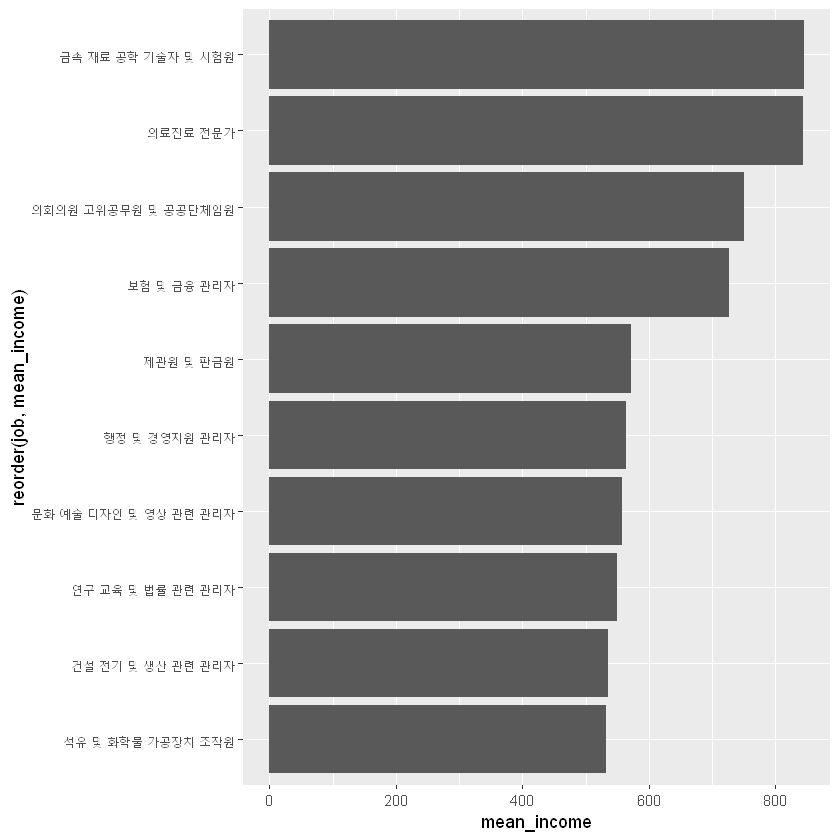

In [36]:
#### 3. 그래프 만들기
ggplot(data = top10, aes(x = reorder(job, mean_income), y = mean_income)) +
  geom_col() +
  coord_flip() # 옆으로 늬어서 보여줌

In [37]:
# 하위 10개
bottom10 <- job_income %>%
  arrange(mean_income) %>%
  head(10)
bottom10

job,mean_income
가사 및 육아 도우미,80.16648
임업관련 종사자,83.33000
기타 서비스관련 단순 종사원,88.22101
청소원 및 환경 미화원,88.78775
약사 및 한약사,89.00000
작물재배 종사자,92.00000
농립어업관련 단순 종사원,101.58125
의료 복지 관련 서비스 종사자,103.52643
음식관련 단순 종사원,107.84511
판매관련 단순 종사원,116.82203


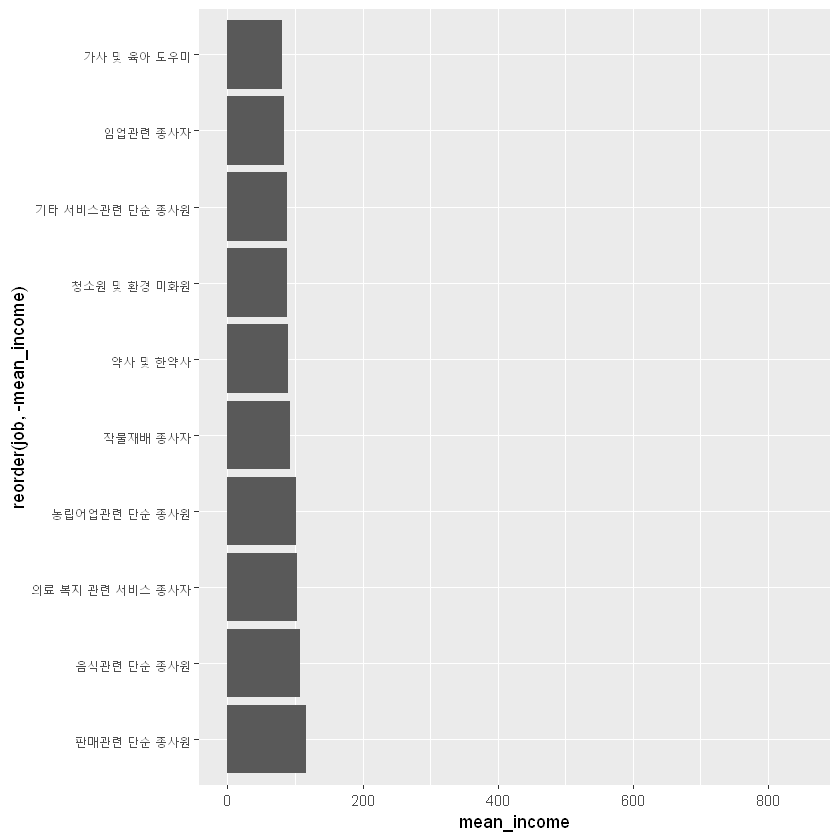

In [38]:
#### 5. 그래프 만들기
# reordered 해서 직업기준으로 해서 보면.
ggplot(data = bottom10, aes(x = reorder(job, -mean_income),
                            y = mean_income)) +
  geom_col() +
  coord_flip() +
  ylim(0, 850)

## 09-7. 성별 직업 빈도

## - "성별로 어떤 직업이 가장 많을까?"

#### 분석 절차
**1. 변수 검토 및 전처리**
  
- 성별
- 직업

**2. 변수 간 관계 분석**
  
- 성별 직업 빈도표 만들기
- 그래프 만들기

In [39]:
# 남성 직업 빈도 상위 10개 추출
job_male <- welfare %>%
  filter(!is.na(job) & sex == "male") %>%
  group_by(job) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(10)
job_male

job,n
작물재배 종사자,640
자동차 운전원,251
경영관련 사무원,213
영업 종사자,141
매장 판매 종사자,132
제조관련 단순 종사원,104
청소원 및 환경 미화원,97
건설 및 광업 단순 종사원,95
경비원 및 검표원,95
행정 사무원,92


In [40]:
# 여성 직업 빈도 상위 10개 추출
job_female <- welfare %>%
  filter(!is.na(job) & sex == "female") %>%
  group_by(job) %>%
  summarise(n = n()) %>%
  arrange(desc(n)) %>%
  head(10)
job_female

job,n
작물재배 종사자,680
청소원 및 환경 미화원,228
매장 판매 종사자,221
제조관련 단순 종사원,185
회계 및 경리 사무원,176
음식서비스 종사자,149
주방장 및 조리사,126
가사 및 육아 도우미,125
의료 복지 관련 서비스 종사자,121
음식관련 단순 종사원,104


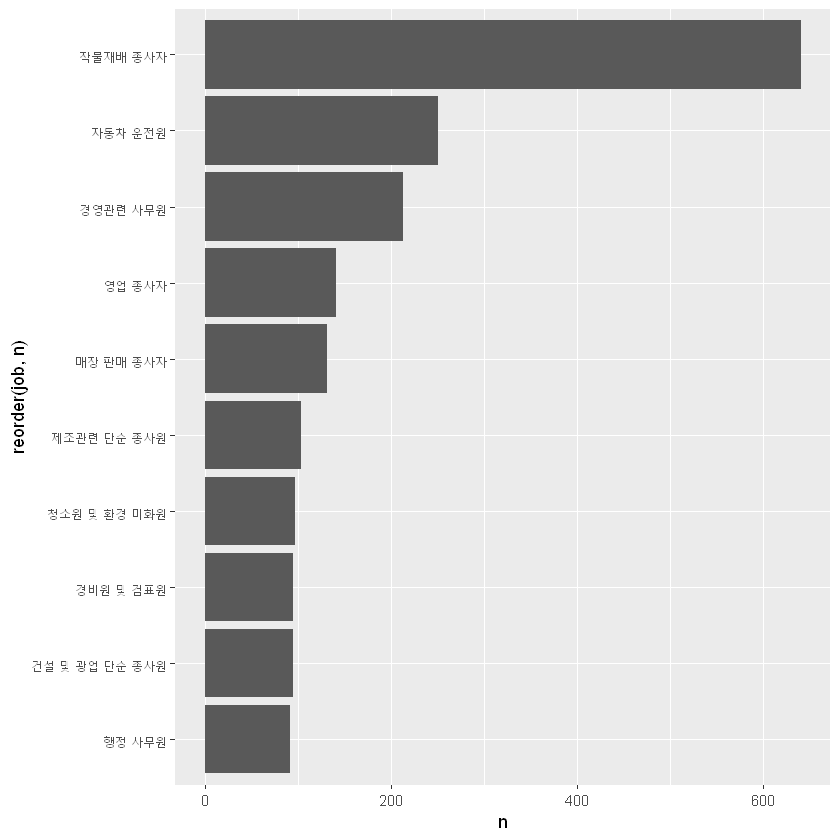

In [41]:
# 남성 직업 빈도 상위 10개 직업
ggplot(data = job_male, aes(x = reorder(job, n), y = n)) +
  geom_col() +
  coord_flip()

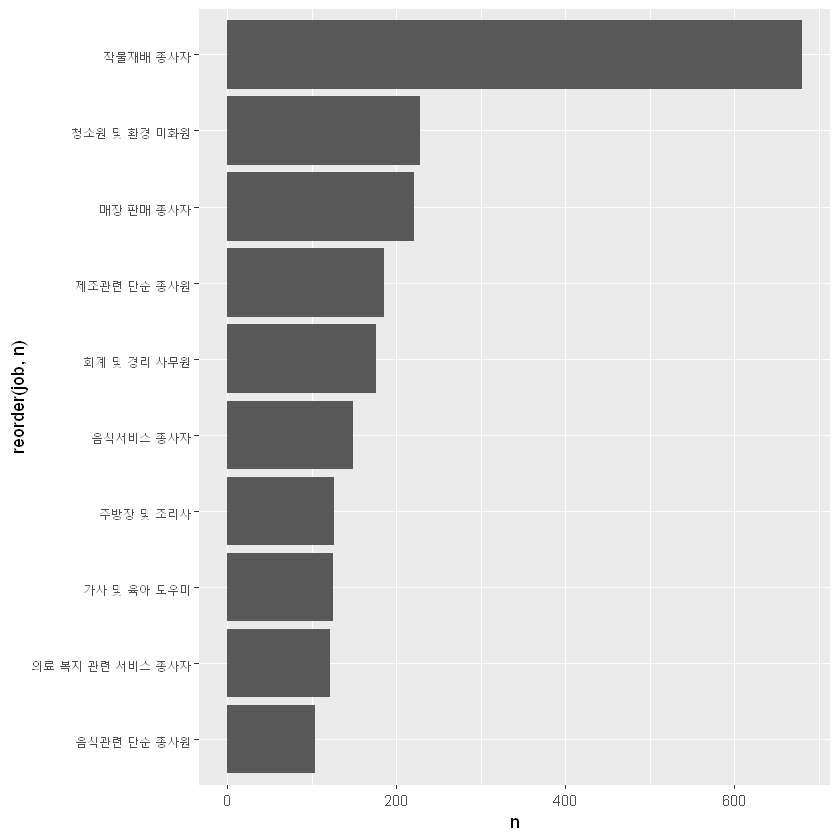

In [42]:
# 여성 직업 빈도 상위 10개 직업
ggplot(data = job_female, aes(x = reorder(job, n), y = n)) +
  geom_col() +
  coord_flip()

## 09-9. 지역별 연령대 비율

## - "노년층이 많은 지역은 어디일까?"

#### 분석 절차

**1. 변수 검토 및 전처리**
  
- 지역
- 연령대

**2. 변수 간 관계 분석**
  
- 지역별 연령대 비율표 만들기
- 그래프 만들기

In [43]:
class(welfare$code_region)

[1] "numeric"

In [44]:
# 1 ~ 7 까징 지역 코드에 따른 갯수를 살필수 있다.
table(welfare$code_region)


   1    2    3    4    5    6    7 
2486 3711 2785 2036 1467 1257 2922 

In [45]:
# 지역 코드 목록 만들기
list_region <- data.frame(code_region = c(1:7),
                          region = c("서울",
                                     "수도권(인천/경기)",
                                     "부산/경남/울산",
                                     "대구/경북",
                                     "대전/충남",
                                     "강원/충북",
                                     "광주/전남/전북/제주도"))
list_region

code_region,region
1,서울
2,수도권(인천/경기)
3,부산/경남/울산
4,대구/경북
5,대전/충남
6,강원/충북
7,광주/전남/전북/제주도


In [46]:
#### `welfare`에 지역명 변수 추가
welfare <- left_join(welfare, list_region, id = "code_region")

Joining, by = "code_region"


In [47]:
welfare %>%
  select(code_region, region) %>%
  head

code_region,region
1,서울
1,서울
1,서울
1,서울
1,서울
1,서울


In [48]:
# 지역별 연령비율
region_ageg <- welfare %>%
  group_by(region, ageg) %>%
  summarise(n = n()) %>%
  mutate(tot_group = sum(n)) %>%
  mutate(pct = round(n/tot_group*100, 2))

# region_ageg <- welfare %>%
#   count(region, ageg) %>%
#   group_by(region) %>%
#   mutate(pct = round(n/sum(n)*100, 2))

head(region_ageg)

region,ageg,n,tot_group,pct
강원/충북,middle,417,1257,33.17
강원/충북,old,555,1257,44.15
강원/충북,young,285,1257,22.67
광주/전남/전북/제주도,middle,947,2922,32.41
광주/전남/전북/제주도,old,1233,2922,42.20
광주/전남/전북/제주도,young,742,2922,25.39


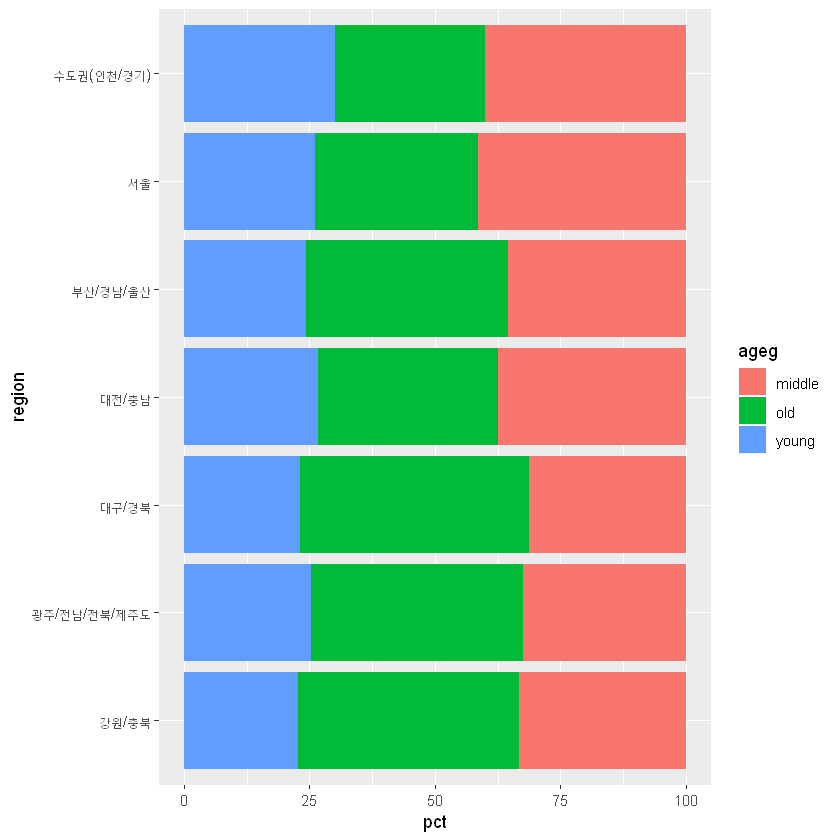

In [49]:
ggplot(data = region_ageg, aes(x = region, y = pct, fill = ageg)) +
  geom_col() +
  coord_flip()